# Online EdX experiment evaluation
A/B experiment was conducted on [CaltechDelftX: QuCryptox Quantum cryptography](https://courses.edx.org/courses/course-v1:CaltechDelftX+QuCryptox+3T2016) MOOC course offered by **Caltech** University and **TU Delft** at **EdX platform**. We are evaluating our proposed **question routing (recommendation of new questions) framework**. Users were split into three groups:

1. Question recommendation with educational-context group
2. Question recommendation without educational-context group
3. Control group without question recommendation


Course lasted 11 weeks from 3.10.2016 to 20.12.2016.

Online experiment started 14.11.2016 (start of week \#6). 

In [75]:
# imports
import pandas as pd, numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import psycopg2 as pg
import pandas.io.sql as psql
import matplotlib
matplotlib.style.use('ggplot')
from IPython.display import display

# graphics setup
%matplotlib inline
sns.set(color_codes=True)

# set up connection to the database
connection = pg.connect(database="askalot_edx_development", user="postgres", port=5432, 
                        host="localhost", password="")

## A/B groups statistics

### Users count

In [76]:
users = psql.read_sql("SELECT g.id, g.value, COUNT(*) FROM ab_groupings ab "+
                      "JOIN ab_groups g ON g.id=ab.ab_group_id GROUP BY g.id", connection)
users

,id,value,count
0,1,Question routing full,1304
1,3,Control group for question routing,1309
2,2,Question routing baseline,1305


### Total number of recommended questions to group number 1 and 2

In [77]:
answers_count = psql.read_sql("""
                                SELECT COUNT(DISTINCT(resource_id)) AS total_recommended_questions 
                                FROM notifications as n 
                                JOIN ab_groupings ab ON ab.user_id = n.recipient_id 
                                WHERE n.action = 'recommendation' AND n.created_at < '2016-12-20'
                              """, connection)
answers_count

,total_recommended_questions
0,124


### Recommendation click-through rate

In [78]:
ctr = psql.read_sql("""   
    SELECT COUNT(*) as absolute_count, CAST(COUNT(*) AS FLOAT) / (SELECT COUNT(*) FROM notifications WHERE action= 'recommendation' AND created_at < '2016-12-20') as total_ctr
    FROM notifications as n WHERE n.action= 'recommendation' AND n.unread = FALSE AND n.created_at < '2016-12-20'
    """,connection)
display(ctr)

ctr_from_dashboard = psql.read_sql("""   
    SELECT COUNT(*) as absolute_count, CAST(COUNT(*) AS FLOAT) / (SELECT COUNT(*) FROM notifications WHERE action= 'recommendation' AND unread=FALSE) as ctr_from_dashboard 
    FROM notifications as n WHERE n.action= 'recommendation' AND from_dashboard = TRUE    """,connection)
display(ctr_from_dashboard)

ctr_by_groups = psql.read_sql("""
    SELECT ab.ab_group_id, CAST(COUNT(*) AS FLOAT) / (SELECT COUNT(*) FROM notifications WHERE action= 'recommendation' AND created_at < '2016-12-20') as portion
    FROM notifications as n 
    INNER JOIN ab_groupings ab ON ab.user_id = n.recipient_id
    WHERE n.action= 'recommendation' AND n.unread = FALSE AND n.created_at < '2016-12-20'
    GROUP BY ab.ab_group_id
    """, connection)
ctr_by_groups

,absolute_count,total_ctr
0,518,0.208871


,absolute_count,ctr_from_dashboard
0,74,0.130511


,ab_group_id,portion
0,1,0.112097
1,2,0.089113
2,3,0.007661


### Recommendation success rate
Users who post an answer or comment to a recommended questions.

In [79]:
success_rec = psql.read_sql("""
    SELECT ab.ab_group_id, n.id as n_id, n.created_at, n.unread, n.read_at, n.from_dashboard, q.title, q.author_id, q.text, q.created_at, a.author_id, a.text, a.created_at
    FROM notifications as n INNER JOIN questions q ON q.id = n.resource_id INNER JOIN answers a ON n.recipient_id = a.author_id AND q.id=a.question_id 
    INNER JOIN ab_groupings ab ON ab.user_id = n.recipient_id WHERE n.action= 'recommendation'
    UNION ALL
    SELECT ab.ab_group_id, n.id as n_id, n.created_at, n.unread, n.read_at, n.from_dashboard, q.title, q.author_id, q.text, q.created_at, c.author_id, c.text, c.created_at
    FROM notifications as n INNER JOIN questions q ON q.id = n.resource_id INNER JOIN comments c ON n.recipient_id = c.author_id AND q.id=c.commentable_id 
    INNER JOIN ab_groupings ab ON ab.user_id = n.recipient_id WHERE n.action= 'recommendation' AND c.commentable_type = 'Shared::Question'
    """,connection)
success_rec.groupby('ab_group_id')['n_id'].count()

ab_group_id
1    23
2     5
3     1
Name: n_id, dtype: int64

Question routing with educational-context has better recommendation success rate.

Note: User in ab_group number 3 is my colleage and he was moved away from group number 2 during the course.

### Questions count

In [80]:
questions_end = psql.read_sql("SELECT q.author_id, ab.ab_group_id FROM questions q JOIN ab_groupings ab ON q.author_id = ab.user_id "+
                          "WHERE q.created_at >= '2016-11-14' AND q.created_at < '2016-12-20'", connection)
questions_start = psql.read_sql("SELECT q.author_id, ab.ab_group_id FROM questions q JOIN ab_groupings ab ON q.author_id = ab.user_id "+
                          "WHERE q.created_at < '2016-11-14'", connection)

print("Questions before online experiment: %d" % questions_start.shape[0])
print("Questions during online experiment: %d" % questions_end.shape[0])

Questions before online experiment: 406
Questions during online experiment: 119


Note: Deletion of some questions by users cause the difference between recommended questions and total number of questions during online experiment.

### Answers count

In [81]:
answers_end = psql.read_sql("SELECT a.author_id, ab.ab_group_id FROM answers a JOIN ab_groupings ab ON a.author_id = ab.user_id "+
                          "WHERE a.created_at >= '2016-11-14' AND a.created_at < '2016-12-20'", connection)
answers_start = psql.read_sql("SELECT a.author_id, ab.ab_group_id FROM answers a JOIN ab_groupings ab ON a.author_id = ab.user_id "+
                          "WHERE a.created_at < '2016-11-14'", connection)
# professor - AND a.author_id != 4

print("Answers before online experiment: %d" % answers_start.shape[0])
print("Answers during online experiment: %d" % answers_end.shape[0])

Answers before online experiment: 355
Answers during online experiment: 133


### Comments count

In [82]:
comments_end = psql.read_sql("SELECT c.author_id, ab.ab_group_id FROM comments c JOIN ab_groupings ab ON c.author_id = ab.user_id "+
                          "WHERE c.created_at >= '2016-11-14' AND c.created_at < '2016-12-20'", connection)
comments_start = psql.read_sql("SELECT c.author_id, ab.ab_group_id FROM comments c JOIN ab_groupings ab ON c.author_id = ab.user_id "+
                          "WHERE c.created_at < '2016-11-14'", connection)

print("Coments before online experiment: %d" % comments_start.shape[0])
print("Comments during online experiment: %d" % comments_end.shape[0])

Coments before online experiment: 430
Comments during online experiment: 169


### Question views count

Question views before online experiment: 13721
Question views during online experiment: 7572
Question views before:
ab_group_id
1    3824
2    4857
3    5040
Name: viewer_id, dtype: int64
Question views during:
ab_group_id
1    2993
2    2622
3    1957
Name: viewer_id, dtype: int64


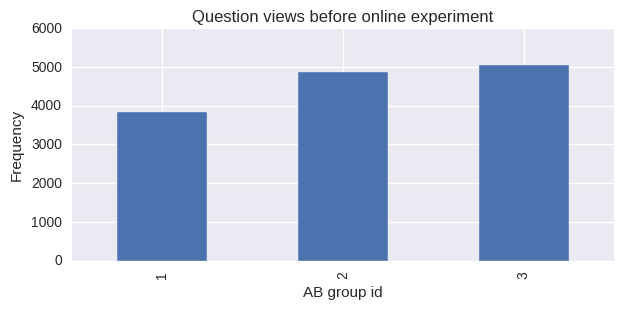

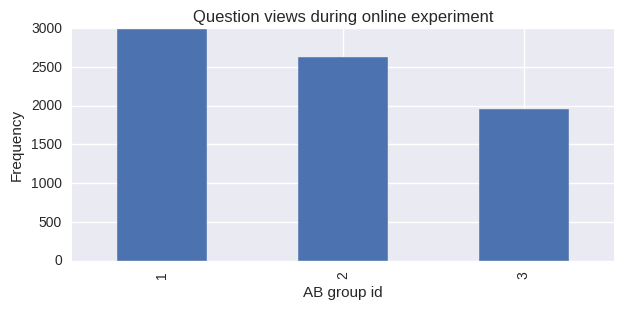

In [83]:
# read questions and filter columns
views_end = psql.read_sql("SELECT v.viewer_id, ab.ab_group_id FROM views v JOIN ab_groupings ab ON v.viewer_id = ab.user_id "+
                          "WHERE v.created_at >= '2016-11-14' AND v.created_at < '2016-12-20'", connection)
views_start = psql.read_sql("SELECT v.viewer_id, ab.ab_group_id FROM views v JOIN ab_groupings ab ON v.viewer_id = ab.user_id "+
                          "WHERE v.created_at < '2016-11-14'", connection)

print("Question views before online experiment: %d" % views_start.shape[0])
print("Question views during online experiment: %d" % views_end.shape[0])


# Histogram views before
views_by_groups = views_start.groupby('ab_group_id')["viewer_id"].count()
print("Question views before:")
print(views_by_groups)
plt.figure(figsize=(7,3))
ax = views_by_groups.plot(kind="bar", title="Question views before online experiment")
ax.set(xlabel='AB group id', ylabel='Frequency')

# Histogram views during
views_by_groups = views_end.groupby('ab_group_id')["viewer_id"].count()
print("Question views during:")
print(views_by_groups)
plt.figure(figsize=(7,3))
ax = views_by_groups.plot(kind="bar", title="Question views during online experiment")
ax.set(xlabel='AB group id', ylabel='Frequency')

In [84]:
# Create before and during dataframe with answer, question and comments counts

# Before
# questions
question_by_groups = questions_start.groupby('ab_group_id')["author_id"].count()
start_df = question_by_groups.to_frame(name = 'questions_count').reset_index()
# answers
answers_by_groups = answers_start.groupby('ab_group_id')["author_id"].count()
temp = answers_by_groups.to_frame(name = 'answers_count').reset_index()
start_df = pd.merge(start_df, temp, on='ab_group_id', how='inner')
# comments
comments_by_groups = comments_start.groupby('ab_group_id')["author_id"].count()
temp = comments_by_groups.to_frame(name = 'comments_count').reset_index()
start_df = pd.merge(start_df, temp, on='ab_group_id', how='inner')

# During
# questions
question_by_groups = questions_end.groupby('ab_group_id')["author_id"].count()
end_df = question_by_groups.to_frame(name = 'questions_count').reset_index()
# answers
answers_by_groups = answers_end.groupby('ab_group_id')["author_id"].count()
temp = answers_by_groups.to_frame(name = 'answers_count').reset_index()
end_df = pd.merge(end_df, temp, on='ab_group_id', how='inner')
# comments
comments_by_groups = comments_end.groupby('ab_group_id')["author_id"].count()
temp = comments_by_groups.to_frame(name = 'comments_count').reset_index()
end_df = pd.merge(end_df, temp, on='ab_group_id', how='inner')

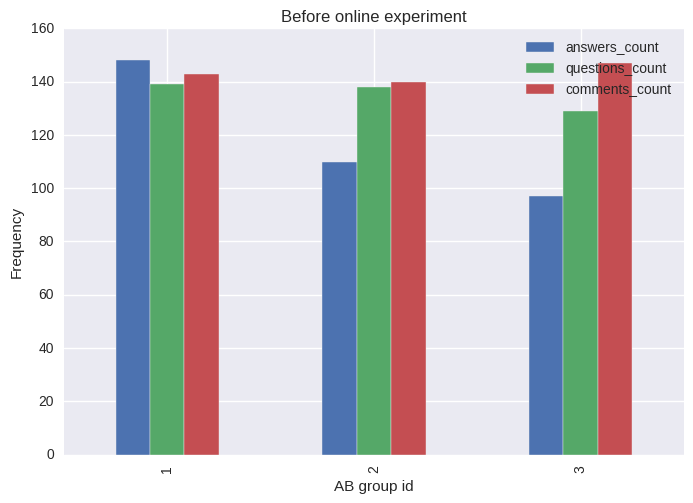

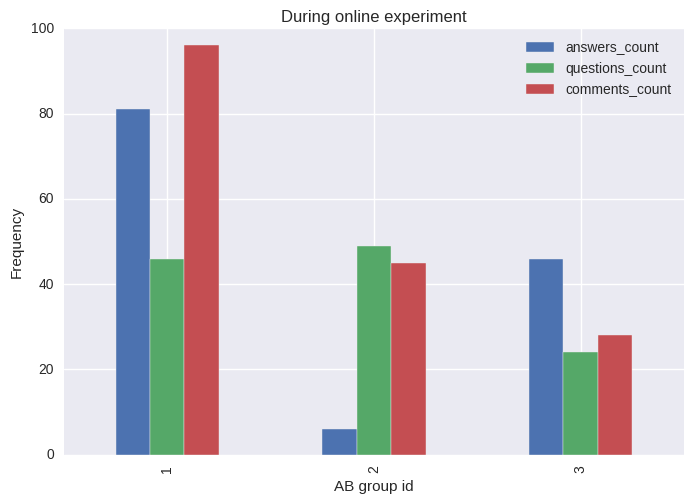

In [85]:
# Before
plt.figure(figsize=(7,3))
ax = start_df.groupby('ab_group_id')["answers_count", "questions_count", "comments_count"].sum().plot(kind="bar", 
                                                                                                      title="Before online experiment")
ax.set(xlabel='AB group id', ylabel='Frequency')

# During
plt.figure(figsize=(7,3))
ax = end_df.groupby('ab_group_id')["answers_count", "questions_count", "comments_count"].sum().plot(kind="bar", title="During online experiment")
ax.set(xlabel='AB group id', ylabel='Frequency')

In [86]:
# comparison between before and during - percentage increase
df = pd.merge(start_df, end_df, on='ab_group_id', how='inner', suffixes=['_start', '_end'])
df['questions_count_change']= df['questions_count_end']*100 / df['questions_count_start']
df['answers_count_change']= df['answers_count_end']*100 / df['answers_count_start']
df['comments_count_change']= df['comments_count_end']*100 / df['comments_count_start']
df.head()

,ab_group_id,questions_count_start,answers_count_start,comments_count_start,questions_count_end,answers_count_end,comments_count_end,questions_count_change,answers_count_change,comments_count_change
0,1,139,148,143,46,81,96,33.093525,54.729730,67.132867
1,2,138,110,140,49,6,45,35.507246,5.454545,32.142857
2,3,129,97,147,24,46,28,18.604651,47.422680,19.047619


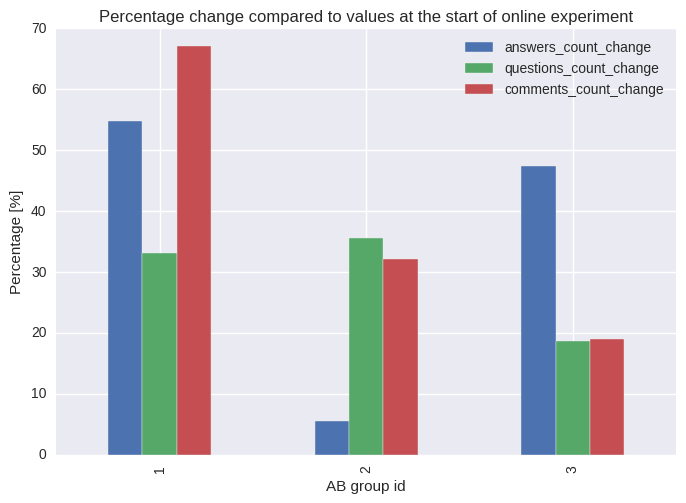

In [87]:
plt.figure(figsize=(7,3))
ax = df.groupby('ab_group_id')["answers_count_change", "questions_count_change", "comments_count_change"].sum()\
    .plot(kind="bar", title="Percentage change compared to values at the start of online experiment")
ax.set(xlabel='AB group id', ylabel='Percentage [%]')

### Unique users with answers and comments
Comparing contributing users (answering, commenting) before the online experiment and during the online experiment?

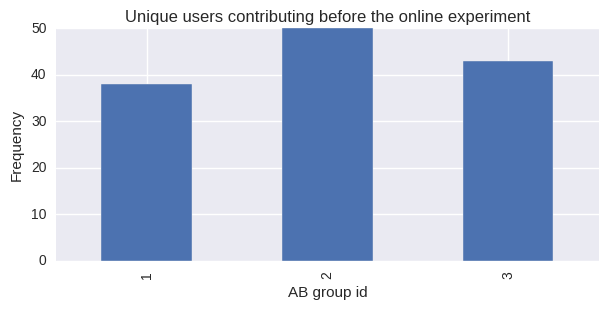

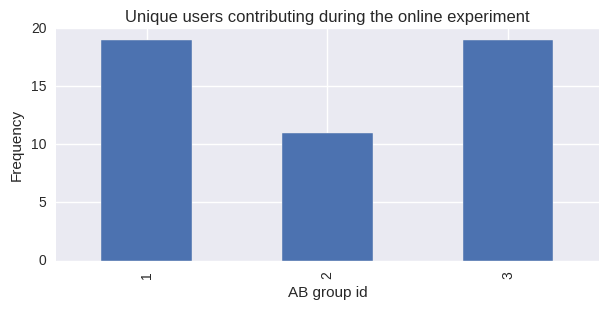

In [88]:
users_start = psql.read_sql("""
    SELECT DISTINCT(a.author_id), a.ab_group_id FROM
    ((SELECT a.author_id, ab.ab_group_id FROM answers a JOIN ab_groupings ab ON a.author_id = ab.user_id
    WHERE a.created_at < '2016-11-14')
    UNION ALL
    (SELECT c.author_id, ab.ab_group_id FROM comments c JOIN ab_groupings ab ON c.author_id = ab.user_id
    WHERE c.created_at < '2016-11-14')
    ) as a
    """, connection)

users_during = psql.read_sql("""
    SELECT DISTINCT(a.author_id), a.ab_group_id FROM
    ((SELECT a.author_id, ab.ab_group_id FROM answers a JOIN ab_groupings ab ON a.author_id = ab.user_id
    WHERE a.created_at >= '2016-11-14' AND a.created_at < '2016-12-20')
    UNION ALL
    (SELECT c.author_id, ab.ab_group_id FROM comments c JOIN ab_groupings ab ON c.author_id = ab.user_id
    WHERE c.created_at >= '2016-11-14' AND c.created_at < '2016-12-20')
    ) as a
    """, connection)

plt.figure(figsize=(7,3))
ax = users_start.groupby('ab_group_id')["author_id"].count().plot(kind="bar", title="Unique users contributing before the online experiment")
ax.set(xlabel='AB group id', ylabel='Frequency')

plt.figure(figsize=(7,3))
ax = users_during.groupby('ab_group_id')["author_id"].count().plot(kind="bar", title="Unique users contributing during the online experiment")
ax.set(xlabel='AB group id', ylabel='Frequency')

## Recommendation coverage
How many unique users did get the recommendation? 

Active users are users who have seen at least one question in CQA system.

In [89]:
users_coverage = psql.read_sql("""
    WITH active_users AS (
      SELECT COUNT(*) from users u JOIN ab_groupings ab ON u.id = ab.user_id 
      WHERE u.views_count > 0 AND ab.ab_group_id != 3
    )
    SELECT COUNT(DISTINCT(ab.user_id)) AS total_recommended_to_users, (SELECT * FROM active_users) AS total_active_users, 
           COUNT(DISTINCT(ab.user_id)) / (SELECT * FROM active_users)::float AS user_coverage 
    FROM notifications as n 
    JOIN ab_groupings ab ON ab.user_id = n.recipient_id 
    WHERE n.action = 'recommendation' AND n.created_at < '2016-12-20'
    """, connection)
users_coverage

,total_recommended_to_users,total_active_users,user_coverage
0,268,664,0.403614


Proposed question routing framework has covered 40.36% of users. 

## Success rate
Success rate is number of questions with at least one answer.

Note: Hello topics are removed as an answer is not expected to them. Only questions are considered, not discussions and bug reports.

In [90]:
questions_before = psql.read_sql("""
            SELECT q.id, q.title, COUNT(a.id) AS answers_count FROM questions q 
            LEFT JOIN answers a ON (a.question_id=q.id AND a.created_at < '2016-11-14')
            WHERE q.created_at < '2016-11-14' 
            AND lower(q.title) NOT SIMILAR TO '%\m(hello|hi|greetings)\M%' AND question_type_id = 1 
            GROUP BY q.id
            """,connection)

questions_during = psql.read_sql("""
            SELECT q.id, q.title, COUNT(a.id) AS answers_count FROM questions q 
            LEFT JOIN answers a ON (a.question_id=q.id AND a.created_at >= '2016-11-14' 
                                    AND a.created_at < '2016-12-20')
            WHERE q.created_at >= '2016-11-14' AND q.created_at < '2016-12-20' AND question_type_id = 1 
            AND lower(q.title) NOT SIMILAR TO '%\m(hello|hi|greetings)\M%' 
            GROUP BY q.id
            """,connection)
before_success_rate = (questions_before['answers_count'] != 0).sum()*100 / float(len(questions_before))
during_success_rate = (questions_during['answers_count'] != 0).sum()*100 / float(len(questions_during))

print("Success rate before online experiment: %.3f %%" % before_success_rate)
print("Success rate during online experiment: %.3f %%" % during_success_rate)

Success rate before online experiment: 74.405 %
Success rate during online experiment: 77.922 %


### Average quality of answers
Quality of answers is estimated by number of earned votes for a particular answer.

In [91]:
quality = psql.read_sql("""
            SELECT (SELECT AVG(votes_difference) FROM answers a
            WHERE a.created_at < '2016-11-14') as quality_before, (SELECT AVG(votes_difference) FROM answers a
            WHERE a.created_at >= '2016-11-14' AND a.created_at < '2016-12-20') as quality_during
          """, connection)
quality

,quality_before,quality_during
0,0.414085,0.410072


Answer quality did not change with a recommendation.

### Average time to answer

In [92]:
before_answers_time = psql.read_sql("""
            SELECT q.id, q.created_at, MIN(a.created_at) AS first_answer_time FROM questions q
            JOIN answers a ON (a.question_id=q.id AND a.created_at < '2016-11-14')
            WHERE q.created_at < '2016-11-14'
            GROUP BY q.id
            """,connection)

during_answers_time = psql.read_sql("""
            SELECT q.id, q.created_at, MIN(a.created_at) AS first_answer_time FROM questions q
            JOIN answers a ON (a.question_id=q.id AND a.created_at >= '2016-11-14' AND a.created_at < '2016-12-20')
            WHERE q.created_at >= '2016-11-14' AND q.created_at < '2016-12-20'
            GROUP BY q.id
            """,connection)

print("Average time to answer before online experiment")
avg_time_before = (before_answers_time['first_answer_time'] - before_answers_time['created_at']).sum() / len(before_answers_time) 
print(avg_time_before)

print("Average time to answer during online experiment")
avg_time_during = (during_answers_time['first_answer_time'] - during_answers_time['created_at']).sum() / len(during_answers_time)
print(avg_time_during)

print("Average time to answer incresed with question recommendation by:")
print(avg_time_during - avg_time_before)

Average time to answer before online experiment
1 days 09:11:28.358339
Average time to answer during online experiment
1 days 15:09:54.905977
Average time to answer incresed with question recommendation by:
0 days 05:58:26.547638


### Contributing users for each week compared to active users in a week
Contribution is defined as asking, answering and commenting. Active user is a user who saw any question during a particular week.

In [93]:
contributing_users = psql.read_sql("""
    SELECT date_trunc('week', a.created_at::date) AS weekly, COUNT(DISTINCT(a.initiator_id)) as contributing_users_count
    FROM activities a
    WHERE a.resource_type IN ('Shared::Question', 'Shared::Answer', 'Shared::Comment')
    AND a.created_at > '2016-10-03' AND a.created_at < '2016-12-19' AND a.action='create'
    GROUP BY weekly
    ORDER BY weekly
          """, connection)
active_users = psql.read_sql("""
    SELECT date_trunc('week', a.created_at::date) AS weekly, COUNT(DISTINCT(a.initiator_id)) as active_users_count FROM activities a
    WHERE a.resource_type IN ('Shared::View')
    AND a.created_at > '2016-10-03' AND a.created_at < '2016-12-19' AND a.action='create'
    GROUP BY weekly
    ORDER BY weekly
          """, connection)
users = pd.merge(contributing_users, active_users, on='weekly', how='inner')
users['contributing_users_count']*100 / users['active_users_count']

0     20.689655
1     21.802326
2     27.433628
3     23.295455
4     21.600000
5     22.916667
6     20.740741
7     19.014085
8     17.361111
9     14.383562
10    20.253165
dtype: float64